#Towards an approach to multivariate outlier detection for District Heating System data

In this notebook, we test different methods for multivariate detection of outliers in the data of transmitted heat energy in the selected substation of local District Heating System, by also considering outside ambient temperature, namely Z-score (univariate, as a benchmark), Mahalanobis distances, Principal Component Analysis (PCA), Isolation Forest and Hotelling's T-squared test. The overall research aims at uncovering irregular plant operation, with a wider objective of identifying the opportunities for reducing the consumption of gas in central heating plant as well as the CO2 emission. The proposed approach considers specific domain circumstances, such as irrelevance of zero transmitted energy timepoints as indication of off-grid plant. The outcomes of the different methods are discussed with domain experts. It was concluded that PCA, Isolation Forest and Hotelling method provide relevant results. Finally, we adopt the ensemble method (selection based on the agreement of all three methods on the detected outliers) as the final approach.

Before we do anything smart, we map the Google drive so to achieve access to the datasets we will be using.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Some imports, mostly standard ones plus specific methods for multivariate outlier detection and Plotly for interactive presentation of time series data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

from scipy.spatial.distance import mahalanobis
from scipy.stats import f
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import plotly.graph_objs as go
from plotly.subplots import make_subplots

## Introduction

District Heating System (DHS) plant operation refers to the automated or semi-automated management of water temperature and water flow in both the main plant and substation supply lines. This control is based on the overall demand for DHS and the prevailing weather conditions. The total DHS demand is considered by analyzing the transmitted energy per time period, as measured by the calorimeter at the return lines. Normally, this transmitted energy is correlated with the outside ambient temperature, which is used as a main control parameter in DHS plant operation.

DHS are designed to efficiently distribute heat to multiple buildings within a geographical area. Anomalies in data, such as sudden spikes or drops in energy consumption, can indicate inefficiencies or malfunctions in the system. Detecting these anomalies allows for timely intervention to optimize energy usage and minimize waste. Anomalies in data can highlight fluctuations in heating performance, which may result in customer complaints. Identifying and rectifying anomalies promptly enhances service quality and customer contentment. When looking for anomalies beyond the transmitted energy, data can reveal abnormalities in the performance of different components of DHS, such as boilers, pumps and pipes, which may be indicative of impending failures or maintenance needs. Anomaly detection techniques can be used to implement predictive maintenance strategies in district heating systems. By identifying anomalies in equipment or performance data, maintenance schedules can be optimized to reduce downtime and minimize costs. Detecting anomalies in sensor data or measurement errors helps maintain the accuracy and reliability of data used for decision-making and modeling.

Anomaly detection is the problem of highlighting unexpected items or events (differing from a norm) in datasets or data streams. It is often used on time-series data, especially in industries, for fault detection.  There are many different ap-proaches for anomaly detection, from conventional (such as statistical ones, Iso-lation Forest, Principal Component Analysis, etc.) to advanced, based on DL architectures (instance-based anomaly detection (Mingyan Teng, 2010), generative adversarial networks (Li et al., 2019), LSTM-based Encoder-Decoder architec-tures (Malhotra et al., 2016) and others). Although the latter are much more effective, black-box nature of DL networks is considered as significant drawback for application in industrial system, where the explanation of detected anomaly is crucial for root-cause analyses, justification of high-impact shop-floor decisions (such as revision of operation parameters, equipment maintenance, etc.).

In this notebook, we define the initial approach of the overall research to detecting anomalies in data related to heat energy consumption in the local DHS. Our approach explores the feasibility of use of the traditional methods to univariate and multivariate outlier detection, namely z-score (univariate, as a benchmark), Mahalanobis distances, Principal Component Analysis (PCA), Isolation Forest and Hotelling's T-squared test.

##Background

Traditional DHSs are currently governed by a Supervisory Control And Data Acquisition (SCADA) system. This system incorporates various sensors, control mechanisms, and integrated algorithms that adjust operational parameters based on sensor readings. The control of DHS is entirely automated, encompassing both the boiler plant and the district heating substation levels. It also involves the implementation of suitable hot water reset control strategies, such as outdoor air reset or control curves, often represented by a regulation curve with multiple control set points (see Figure below).

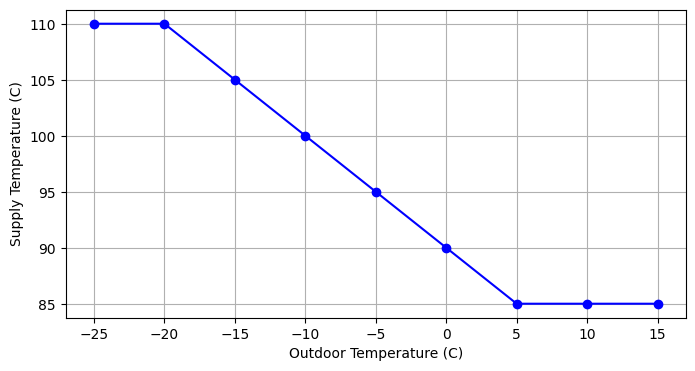

In [3]:
outdoor_temperatures = np.array([-25, -20, -15, -10, -5, 0, 5, 10, 15])
supply_temperatures = np.array([110, 110, 105, 100, 95, 90, 85, 85, 85])
plt.figure(figsize=(8, 4))
plt.plot(outdoor_temperatures, supply_temperatures, marker='o', linestyle='-', color='blue')
plt.xlabel('Outdoor Temperature (C)')
plt.ylabel('Supply Temperature (C)')
plt.grid(True)
plt.show()

Selected substation scheme is presented in figure below. Heat fluid flow takes place in primary and secondary lines, separated by the heat exchanger. The central heating plant generates hot water or steam as a heat carrier. This high-temperature fluid carries thermal energy from the plant to the various consumers, namely the substations. This is a primary supply line.

At the substation, the high-temperature fluid from the central plant passes through a heat exchanger. This heat exchanger is typically designed to transfer heat from the central fluid to a separate, closed-loop system, from primary to secondary supply line. In the closed-loop system, the fluid is pumped to the individual customer's heating system (through branches). This closed loop prevents the central heating fluid from mixing with the customer's internal system.

After transferring its heat to the customer's closed-loop system, the temperature of the fluid in the substation decreases. This cooled fluid returns to the substation. This is a secondary return line. At the substation, the cooled fluid is reheated using heat from the central heating plant. The heat exchanger in the substation facilitates this process. Transmitted heat energy is measured at the calorimeter which is located at the primary return line. This energy is proportional to the difference between temperatures in secondary supply and return lines and flow in a secondary line.



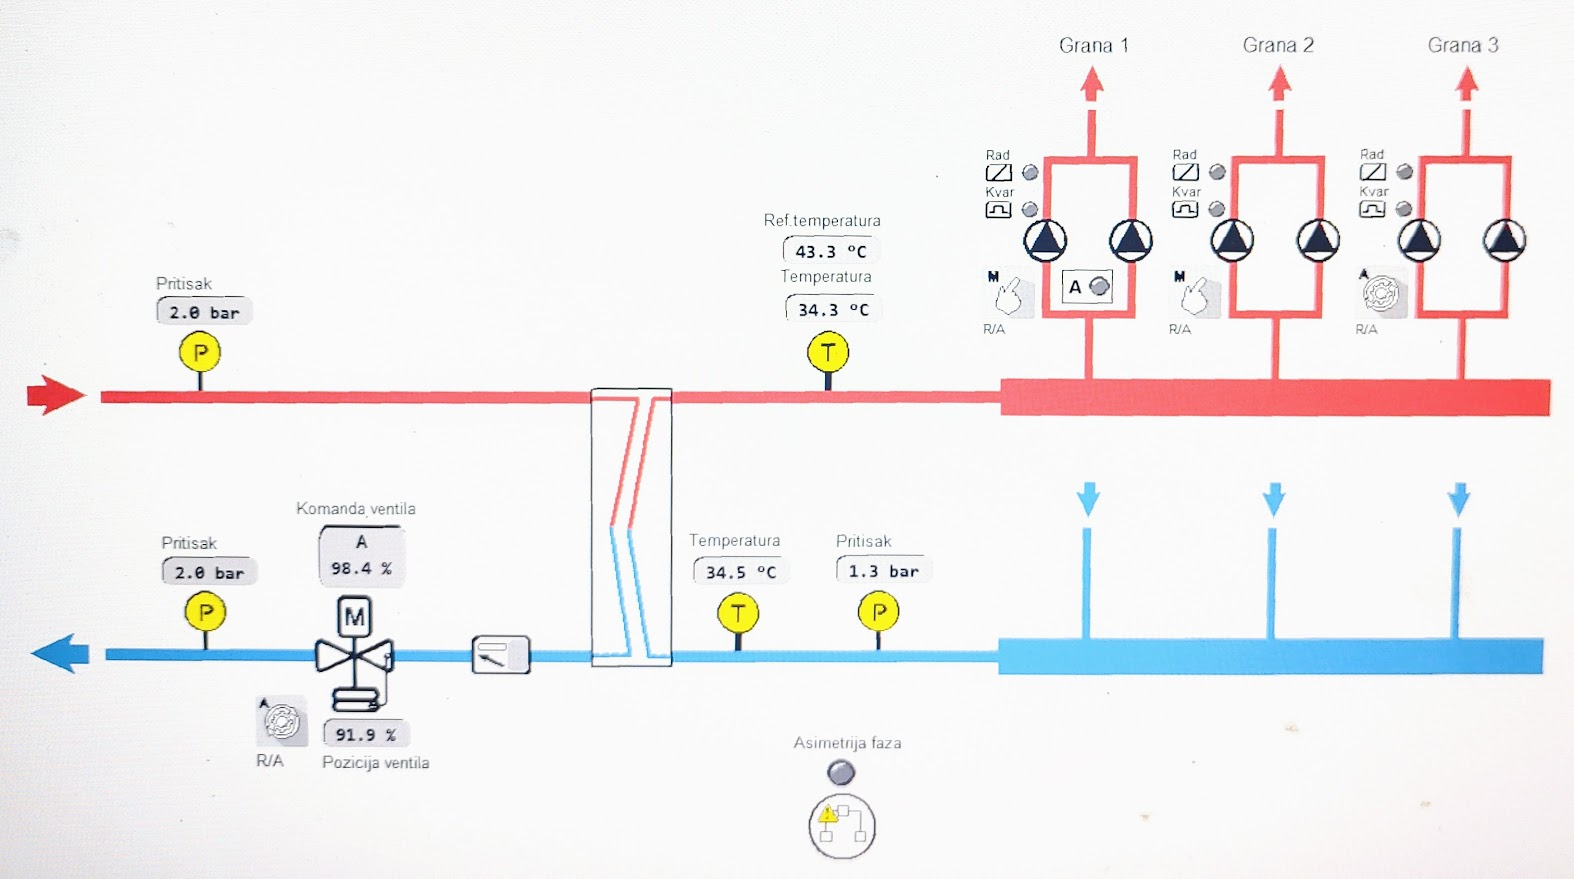

In [ ]:
filename='/content/drive/MyDrive/Projects/FondZaNauku/Prizma/Research/Anomaly detection/Images/substation8.png'
display(Image(filename=filename, width=800))

###Detecting faults and anomalies in DHS

Anomaly detection involves identifying patterns in data that deviate from the expected behavior, often referred to as outliers or aberrations (Chandola et al., 2009).

In data analysis, outlying observations can significantly impact results, emphasizing the need for robust statistical methods (or other methods) to identify and mitigate their influence. Robust statistics focus on detecting outliers by identifying the model that best fits most of the data. (Rousseeuw & Hubert, 2011) present an overview of various robust methods and outlier detection tools, addressing univariate, low-dimensional, and high-dimensional data. The discussion encompasses robust procedures for estimating location and scatter, handling linear regression, Principal Component Analysis (PCA), and classification, providing a comprehensive exploration of techniques to enhance the reliability of data analysis in the presence of outliers. On the other hand, a fault is characterized as a change in a system that renders it incapable of satisfactory operation and meeting user requirements (Worden & Dulieu-Barton, 2004). The distinction between detecting faults and anomalies in systems is highlighted by (Neumayer et al., 2023).

(Al Koussa, Jad & Månsson, Sara, 2022) present two methods for detecting faults in district heating (DH) substations using energy meter data. The first method is a cluster-based approach, comparing substations within a network to identify sub-optimal performance. The second is an instance-based approach, using a black-box model to predict substation behavior and identify deviations from expected performance. Both methods demonstrate effectiveness in detecting deviating behaviors in DH customer installations, offering a significant advancement in automated fault detection in this field. This distinction underscores the need for precision in discerning irregularities in system behavior, whether they manifest as anomalies or faults.

(Mbiydzenyuy & Sundell, 2022) address the challenge of unsupervised anom-aly detection in District Heating, citing limited labeled data and complex structures. Their solution involves algorithm which employs hierarchical clustering, Dynamic Time Warping, Matrix profiles, and a Generative Adversarial Network to detect anomaly instances with similar patterns to labeled anomalies. The findings demonstrate a strategic approach for energy analysts to assess specific anomalies in the District Heating network, unveiling prevalent cluster patterns within the dataset.

(Zhang & Fleyeh, 2020) introduce a novel hybrid approach for anomaly detection in DHS substations, acknowledging the common occurrence of system underperformance due to various faults. The proposed method combines a simplified physical model with a Long Short-Term Memory-based Variational Autoencoder (LSTM VAE). Using a dataset from an anonymous Swedish substation, the study evaluates and compares the performance of two state-of-the-art models, namely LSTM and Long Short-Term Memory-based Autoencoder (LSTM AE), with LSTM VAE. Results indicate that LSTM VAE outperforms baseline models when applying an optimal threshold.

(Seem, 2007) outlines an innovative approach for identifying abnormal energy consumption in buildings through daily energy readings and peak consumption data. Utilizing outlier detection, the method assesses whether daily energy consumption significantly deviates from previous levels. For buildings exhibiting abnormal energy patterns, robust estimates of mean and standard deviation quantify the variation from the norm. This data analysis technique promises cost reduction by detecting unnoticed issues and saving operational time previously spent on manual fault detection. Successful detection of high-energy consumption in various buildings is demonstrated through field test results, showcasing its efficacy in identifying issues such as chiller failure, suboptimal control strategies, ventilation system design flaws, and improper equipment operation following electrical panel changes.

Within the broader research scope aimed at revealing irregularities in plant operation and ultimately identifying opportunities to reduce gas consumption and CO2 emissions in central heating plants, this paper marks the initial step of the overall research in that trajectory. The paper delves into the exploration of various outlier detection methods, assessing their effectiveness. In collaboration with domain experts, the identified outliers are clarified through their expertise, ultimately determining the suitable approaches for accurate outlier detection in the pursuit of optimizing plant efficiency and environmental sustainability.


## Methodology

Besides the control curve, operation of the DHS follows some rules and patterns that are normally followed by the human operators. For example, in some situations, most often in the morning, a lot of energy is initially sent in order to reach the reference temperature in the secondary supply line. For example, the target reference temperature is 50°C, hence a lot of energy is sent and the temperature in the secondary supply lines rises to 55°C. Then, the sending of energy is switched off or drastically reduced and the system reads on the calorimeter of the primary that there is no delivered energy. This often occurs an hour or two after the start of heating that day. At hours 11, 12, 13, peaks and valleys are expected to be very pronounced, because operators are constantly trying to guess the reference temperature.

Obviously, one daily operation is expected to follow the specific pattern. This pattern includes the peaks that are the result of the operator decisions and valleys which occur when the heating system is off. To avoid detection of above-mentioned peaks as anomalies, in our approach we detect anomalies on the number of datasets, for which data included only transmitted energy and ambient temperature at the given hour. For example, we will separately analyze all data collected at 7:00 and at other hours.

The approach is used on the data corresponding to the specific hours due to a very clear seasonality daily pattern for the transmitted heat energy corresponding to the human operator procedures. The outlier detection approaches will be tested on the daily time series comprising of the ambient temperature and transmitted heat energy at the following hours of a day: 7, 8, 9, 10, 11, 12, 13, 14, 22, 23. Detection will consider both time series, so the bivariate outlier detection approach will be used. Multivariate outliers are data points that are unusual or extreme when considering multiple variables simultaneously. In other words, these are observations that are outliers in a multivariate space. As a reference, a simple statistical Z-score method will be used on transmitted heat energy signal.

### Dataset description

The dataset includes following relevant features:

- Outside air temperature, acquired by the sensor in the substation (C, tsp)
- Reference temperature (C, trt). Reference temperature is a target temperature at secondary supply line which needs to be reached. Reference temperature is calculated by the control curve.
- Water temperature in the secondary supply line (C, tns)
- Water temperature in the secondary return line (C, tps)
- Water temperature in the primary supply line (C, tnp)
- Water temperature in the primary return line (C, tpp)
- Heat energy transmitted (MWh, e)

Data is collected from substation 9 of the local DHS by merging different datasets. The data period is 2018-05-05 - 2023-05-01. Normally, the adopted time of the heating season start is the time of first change in transmitted heat energy after October 1st. The end of the heating season is normally April 15th. Although the heating system often remains operational after that date, till May 3rd, this data is discarded because of high temperature peaks that often occur in this period. Heat energy is measured at the calorimeter which is located at the primary supply line.

Due to special conditions for DHS operation in October, this month will also be omitted from the analysis. For the purpose of data analysis, the adopted period is 11-01 - 04-01.

Normally, heating starts at 7:00 in the morning.

In [ ]:
datapath_processed='/content/drive/MyDrive/Projects/FondZaNauku/Prizma/Research/Data/p9_processed_2.csv'

In [ ]:
df=pd.read_csv(datapath_processed)
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index('Unnamed: 0',inplace=True)

df = df[(df.index < '2020-04-01')]
df['deltae']=(df['e'].shift(-1)-df['e'])*1000
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12402 entries, 2018-11-01 06:00:00 to 2020-03-31 23:00:00
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time_ref     7210 non-null   float64
 1   tsp          7210 non-null   float64
 2   trt          7210 non-null   float64
 3   tns          7210 non-null   float64
 4   tps          7210 non-null   float64
 5   tnp          7210 non-null   float64
 6   tpp          7210 non-null   float64
 7   e            7210 non-null   float64
 8   Unnamed: 9   0 non-null      float64
 9   Unnamed: 10  0 non-null      object 
 10  deltae       7176 non-null   float64
dtypes: float64(10), object(1)
memory usage: 1.1+ MB


<ipython-input-4-de3e252f842b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['deltae']=(df['e'].shift(-1)-df['e'])*1000


###Multivariate outlier detection methods

Z-score as the simplest but often most often univariate outlier detection technique will be used as a reference. Z-score is a statistical measure that quantifies how far is a data point from the mean of the dataset in terms of standard deviations.

$Z = \frac{X - \mu}{\sigma}$

Where:
- Z - z-score.
- X - individual data point you want to standardize.
- μ - mean (average) of the dataset.
- σ - standard deviation of the dataset.

Z-score is commonly used in detection of outliers (univariate analysis) in the dataset, by applying the arbitrarily selected thresholds. Selection of threshold has crucial effect on the reliability of the outlier detection and it should be done by the domain expert. Also, such technique is sensitive to the data distribution; Z-scores assume that the data is normally distributed as they are using mean as a reference. Z-scores are sensitive to skewness (asymmetry) and kurtosis in the data. In the presence of significant skewness or heavy tails, z-scores may misclassify some data points as outliers or fail to identify true outliers. Finally, Z-scores assume that data points are independent of each other. If data points are correlated or exhibit serial dependence (e.g., time series data), z-scores may not be appropriate. However, the negative effect of cross-correlation in time series data may be mitigated by using derivatives instead of the actual datapoint values.

Multivariate outliers are data points that are outliers not in a single variable (univariate outlier) but rather in a multivariate context. Multivariate outliers are detected by considering the relationships between two or more variables. A data point may not be considered an outlier when examining any individual variable but becomes an outlier when analyzing the combination of variables.

Multivariate outliers are important to identify because they can distort statistical analyses, affect the accuracy of predictive models, or carry unique information that researchers may want to investigate further. In the research presented in this paper, the following methods for multivariate (in this case, bivariate) outlier detection are: Mahalanobis distance, Principal Component Analysis (PCA), Isolation Forest and Hotelling's T-squared test. They are described in the remainder of this section.

####Mahalanobis Distance

Mahalanobis Distance is a method used for multivariate outlier detection. It is a measure of the distance between a data point and the center of a dataset in a multidimensional space, taking into account the variability and correlations of the data.

$D(X) = \sqrt{(X - \mu)^T \Sigma^{-1} (X - \mu)}$

where,
- $X$ represents the multivariate data point.
- $\mu$ is the mean vector.
- $\Sigma$ is the covariance matrix.
- $\Sigma^{-1}$ is the inverse of the covariance matrix.

Mahalanobis Distance is robust to data with different scales and units. It can capture correlations and dependencies between variables and it is applicable to high-dimensional datasets. One of the limitations of the method is that it assumes that the data follow a multivariate normal distribution, which may not always be the case.

#### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a dimensionality reduction technique used in multivariate outlier detection. While PCA is primarily known for dimensionality reduction and data compression, it can also be applied to identify outliers in multivariate datasets.

PCA's primary goal is to transform a dataset with multiple correlated variables (features) into a new set of uncorrelated variables called principal components. These components are linear combinations of the original features and capture most of the variance in the data. In PCA, the first few principal components capture the majority of the variance in the dataset, while subsequent components capture less and less. Therefore, the first few components contain the most valuable information about the data. Outliers in a multivariate dataset tend to exhibit significant deviations from the norm along one or more dimensions or combinations of dimensions. By reducing the dimensionality of the data with PCA, outliers can become more apparent in the reduced-dimensional space.

PCA can be used in combination with Mahalanobis Distance to detect multivariate outliers. After applying PCA, the Mahalanobis Distance is calculated for each data point in the reduced-dimensional space.

PCA is particularly useful when dealing with high-dimensional data because it reduces the dimensionality while retaining most of the important information. It can capture complex relationships and correlations among variables, making it suitable for identifying outliers with multivariate dependencies. PCA assumes that the data follow a Gaussian distribution, which may not always hold true for all datasets.

#### Isolation Forest

The Isolation Forest is an ensemble machine learning algorithm used for outlier detection. It operates by randomly selecting a feature and a random split point for that feature. It does this recursively until it isolates an outlier or reaches a specified depth in the tree. The algorithm builds multiple isolation trees, also known as iTrees. Each iTree is constructed as follows:
- Randomly select a feature from the dataset.
- Randomly select a split value for the chosen feature within its range.
- Divide the data into two subsets: one with data points greater than the split value and one with data points less than the split value.
- Repeat the above steps recursively for each subset until a stopping criterion is met (e.g., maximum tree depth or a single data point is isolated).

For each data point, the Isolation Forest measures the average path length required to isolate the data point in the constructed iTrees.Shorter path lengths indicate that the data point is an outlier, as it required fewer splits to isolate it from the rest of the data.

The average path lengths for all data points are averaged across all iTrees. Data points with shorter average path lengths are considered anomalies (outliers), while those with longer average path lengths are considered normal (inliers).

The contamination parameter is used to control the proportion of expected outliers in the dataset. It represents the expected percentage of anomalies in the dataset. The contamination parameter controls the trade-off between precision and recall in outlier detection. A lower value results in stricter detection of outliers.

Some crucial advantages of IF are that it scales well to large datasets, it is capable of identifying anomalies in high-dimensional data, with relatively small tuning effort. Finally, it doesn't require assumptions about the data distribution.

However, there are some limitations. Isolation Forest assumes that anomalies are sparse and can be isolated with fewer splits. While this is often true for many datasets, it may not be the case for all. In some datasets, anomalies may not be isolated efficiently by random partitioning. The method is sensitive to sampling. Isolation Forest relies on random sampling, which can lead to variation in results. Different random samples can produce slightly different isolation trees and, consequently, different outlier scores. The method does not consider data relationships. Isolation Forest treats features independently and doesn't consider the relationships or correlations between features. In some cases, outliers may only be detected by considering multivariate relationships. Thus, it is primarily designed for detecting individual outliers rather than identifying clusters of anomalies. Furthermore, the method is sensitive to data scaling. It is important to preprocess the data appropriately, especially when features have different scales. The explainability is a challenge: Isolation Forest doesn't provide explanations or reasons for why a particular data point is considered an outlier. It only assigns anomaly scores based on path lengths in the trees.

#### Hotelling's T-squared test

Hotelling's T-squared test is a statistical method used for multivariate outlier detection and analysis. It extends the concept of a two-sample t-test to the multivariate setting, making it suitable for identifying outliers or unusual patterns in multivariate data.

Hotelling's T-squared test is designed to identify whether there are significant differences between the means of multivariate datasets. It provides a statistical measure of how far an observation is from the mean of the dataset in a multivariate space. The test compares the Mahalanobis distance (a measure of distance that accounts for correlations between variables) of each observation from the multivariate mean to a critical value derived from the F-distribution.

Hotelling's T-squared test assumes that the data follows a multivariate normal distribution.

## Implementation and discussion

Bivariate detection of outliers is carried out on transmitted energy and outside temperature, where the latter is shifted one timestep in the future, because the decision on increasing the heat energy transmission in the next hour is made based on the temperature in the current hour. This is considered a reasonable simplification, because it assumes system inertia of 1 hour which is not actually correct. This simplification is made because only hourly series data is available for the period of analysis.

Both features are normally distributed which is very positive for great most of the methods for outlier detection which assume the Gaussian distribution. The exception is transmitted energy, where in many datapoints, no energy is being transmitted. This data will be omitted from the analysis of outliers as this is an indication that the plant does not transmit any heat energy.

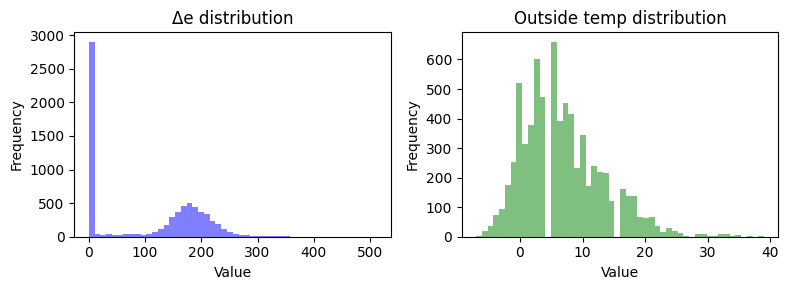

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].hist(df['deltae'], bins=50, alpha=0.5, color='blue')
axes[0].set_title('Δe distribution')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['tsp'], bins=50, alpha=0.5, color='green')
axes[1].set_title('Outside temp distribution')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Outlier detection will be carried out on 11 datasets, each of which contains data for the given hour. The plant starts operation at 7:00. Code below introduces functions for outliers detection. Functions take as parameters a dataframe with time series and parameters for the specific methods.

In [ ]:
def getOutliersZScore(df, threshold):
  df=df[['tsp','deltae']]
  df.dropna()

  d=df['deltae']

  z_scores = np.where(d != 0, (d - np.mean(d[d != 0])) / np.std(d[d != 0]), np.nan)
  z_scores=np.abs(z_scores)
  outliers = df[abs(z_scores) > threshold][['tsp', 'deltae']]
  return outliers

def getOutliersMahalanobisDistances(df, threshold):

  df=df[['tsp','deltae']]
  df.fillna(0, inplace=True)

  deltae_data = df['deltae'].values
  tsp_data = df['tsp'].values
  data = np.column_stack((deltae_data, tsp_data))
  mean = np.nanmean(data, axis=0)
  stddev = np.nanstd(data, axis=0)
  normalized_data = (data - mean) / stddev

  nan_mask = np.isnan(normalized_data).any(axis=1)
  zero_mask = (normalized_data == 0).all(axis=1)
  remove_mask = nan_mask | zero_mask
  filtered_normalized_data = normalized_data[~remove_mask]
  normalized_data=filtered_normalized_data

  cov_matrix = np.cov(normalized_data, rowvar=False)

  mahalanobis_distances = [mahalanobis(point, mean, np.linalg.inv(cov_matrix)) for point in normalized_data]
  mahalanobis_distances_zscores = [(x - np.mean(mahalanobis_distances)) / np.std(mahalanobis_distances) for x in mahalanobis_distances]
  outliers_multivariate = [i for i, distance in enumerate(mahalanobis_distances) if mahalanobis_distances_zscores[i] > threshold]

  dhr=df.reset_index()
  dhr.rename(columns={'index': 'DatetimeIndex'}, inplace=True)
  dhr = dhr[dhr.index.isin(outliers_multivariate)]
  dhr['Unnamed: 0'] = pd.to_datetime(dhr['Unnamed: 0'])
  dhr.set_index('Unnamed: 0',inplace=True)
  dhr = dhr[dhr['deltae'] != 0]
  return dhr[['tsp', 'deltae']]

def getOutliersPCA(df, threshold, components):

  df=df[['tsp','deltae']]
  df.dropna()

  features = ['tsp','deltae']

  nan_mask = df.isna().any(axis=1)
  zero_mask = (df == 0).all(axis=1)
  exclude_mask = nan_mask | zero_mask
  X = df[~exclude_mask]

  X = df[features]
  X.fillna(0, inplace=True)

  scaler = StandardScaler()
  X_std = scaler.fit_transform(X)
  pca = PCA(n_components=components)
  pca.fit(X_std)
  X_pca = pca.transform(X_std)
  mahalanobis_distance = np.sqrt(np.sum(X_pca**2, axis=1))

  outliers_pca = df[mahalanobis_distance > threshold]
  outliers_pca = outliers_pca[outliers_pca['deltae'] != 0]
  return outliers_pca


def getOutliersIsolationForest(df, contamination):

  features = ['tsp', 'deltae']
  df=df[features]
  df.fillna(0, inplace=True)
  model = IsolationForest(contamination=contamination)
  model.fit(df)

  outliers = model.predict(df)
  df['is_outlier'] = outliers

  df = df[df['deltae'] != 0]
  df = df[df['is_outlier'] == -1]
  return df[['tsp','deltae']]


def getOutliersHotelling(df, alpha):
  df=df[['tsp','deltae']]
  df.fillna(0, inplace=True)
  X = df.values

  mean_vector = np.nanmean(X, axis=0)
  cov_matrix = np.cov(X, rowvar=False)

  n = len(X)
  p = X.shape[1]

  t_squared = np.zeros(n)
  for i in range(n):
    x_diff = X[i] - mean_vector
    t_squared[i] = np.dot(np.dot(x_diff, np.linalg.inv(cov_matrix)), x_diff)

  df1 = p
  df2 = n - p - 1

  critical_value = f.ppf(1 - alpha, df1, df2)

  outliers = np.where(t_squared > critical_value)[0]

  dhr=df.reset_index()
  dhr.rename(columns={'index': 'DatetimeIndex'}, inplace=True)
  dhr = dhr[dhr.index.isin(outliers)]
  dhr['Unnamed: 0'] = pd.to_datetime(dhr['Unnamed: 0'])
  dhr.set_index('Unnamed: 0',inplace=True)
  dhr = dhr[dhr['deltae'] != 0]

  return dhr

Outliers are now detected by using the provided methods, by adopting the specific values for the methods' parameters. Before that, an hourly datasets are created.

In [ ]:
hourly_datasets = []
hourly_outliers_deltae=[]
hourly_outliers_deltaetsp=[]
hourly_outliers_deltaetsp_pca=[]
hourly_outliers_deltaetsp_if=[]
hourly_outliers_deltaetsp_hotelling=[]

for hour in range(24):
  dataset_for_hour = df[df.index.hour == hour].copy()

  outliers = getOutliersZScore(dataset_for_hour, 1.96)
  outliers_md = getOutliersMahalanobisDistances(dataset_for_hour, 1)
  outliers_pca = getOutliersPCA(dataset_for_hour, 2.0, 1)
  outliers_if = getOutliersIsolationForest(dataset_for_hour, 0.015)
  outliers_hotelling = getOutliersHotelling(dataset_for_hour, 0.0007)

  hourly_datasets.append(dataset_for_hour)
  hourly_outliers_deltae.append(outliers)
  hourly_outliers_deltaetsp.append(outliers_md)
  hourly_outliers_deltaetsp_pca.append(outliers_pca)
  hourly_outliers_deltaetsp_if.append(outliers_if)
  hourly_outliers_deltaetsp_hotelling.append(outliers_hotelling)

<ipython-input-6-0ac7d243c105>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)
<ipython-input-6-0ac7d243c105>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
<ipython-input-6-0ac7d243c105>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

Ouliers are now plotted, in an overlay of transmitted heat and ambient temperature data per specific hour, for the specific method, for the specific heating season.

In [ ]:
alloutliers=[hourly_outliers_deltae,
             hourly_outliers_deltaetsp,
             hourly_outliers_deltaetsp_pca,
             hourly_outliers_deltaetsp_if,
             hourly_outliers_deltaetsp_hotelling
             ]

titles=['Univariate outlier detection',
        'Multivariate outlier detection - Mahalanobis distances',
        'Multivariate outlier detection - PCA',
        'Multivariate outlier detection - Isolation Forest',
        'Multivariate outlier detection - Hotelling T-test'
]

for hour, dataset in enumerate(hourly_datasets):
 if((hour>6 and hour<15) or hour>21):
  fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14, 12))
  fig.suptitle("ΔE in secondary lines for hour "+str(hour), fontsize=16)
  for i,o in enumerate(alloutliers):

    line1,=axs[i,0].plot(dataset[dataset.index < pd.to_datetime('2019-04-10')].index, dataset[dataset.index < pd.to_datetime('2019-04-10')]['deltae'], linewidth='1', label='ΔE')
    axs[i,0].scatter(o[hour][o[hour].index < pd.to_datetime('2019-04-10')]['deltae'].index, o[hour][o[hour].index < pd.to_datetime('2019-04-10')]['deltae'], c='red', marker='o', s=30, label='Outliers')
    ax2=axs[i,0].twinx()
    ax2.set_ylabel('C')
    line2,=ax2.plot(dataset[dataset.index < pd.to_datetime('2019-04-10')].index, dataset[dataset.index < pd.to_datetime('2019-04-10')].shift(-1)['tsp'], linewidth='1', label='Outside temp', color='r', alpha=0.4)
    axs[i,0].set_title('Season 1: '+titles[i])
    axs[i,0].set_xlabel("Time")
    axs[i,0].set_ylabel('KWh')
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    axs[i,0].legend(lines, labels, loc='upper left', fontsize='small')
    axs[i,0].grid(True)

    line1,=axs[i,1].plot(dataset[dataset.index > pd.to_datetime('2019-10-20')].index, dataset[dataset.index > pd.to_datetime('2019-10-20')]['deltae'], linewidth='1', label='ΔE')
    axs[i,1].scatter(o[hour][o[hour].index > pd.to_datetime('2019-10-20')]['deltae'].index, o[hour][o[hour].index > pd.to_datetime('2019-10-20')]['deltae'], c='red', marker='o', s=30, label='Outliers')
    ax2=axs[i,1].twinx()
    ax2.set_ylabel('C')
    line2,=ax2.plot(dataset[dataset.index > pd.to_datetime('2019-10-20')].index, dataset[dataset.index > pd.to_datetime('2019-10-20')].shift(-1)['tsp'], linewidth='1', label='Outside temp', color='r', alpha=0.4)
    axs[i,1].set_title('Season 2: '+titles[i])
    axs[i,1].set_xlabel("Time")
    axs[i,1].set_ylabel('KWh')
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    axs[i,1].legend(lines, labels, loc='upper left', fontsize='small')
    axs[i,1].grid(True)

  plt.tight_layout()
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

All hourly datasets are now merged to construct the dataframes with all identified outliers per specific method.

In [ ]:
all_outliers_deltae=pd.DataFrame()
all_outliers_deltaetsp=pd.DataFrame()
all_outliers_deltaetsp_pca=pd.DataFrame()
all_outliers_deltaetsp_if=pd.DataFrame()
all_outliers_deltaetsp_hotelling=pd.DataFrame()

for hour in [7, 8, 9, 10, 11, 12, 13, 14, 21, 22, 23]:
  all_outliers_deltae = pd.concat([all_outliers_deltae, hourly_outliers_deltae[hour]])
  all_outliers_deltaetsp = pd.concat([all_outliers_deltaetsp, hourly_outliers_deltaetsp[hour]])
  all_outliers_deltaetsp_pca = pd.concat([all_outliers_deltaetsp_pca, hourly_outliers_deltaetsp_pca[hour]])
  all_outliers_deltaetsp_if = pd.concat([all_outliers_deltaetsp_if, hourly_outliers_deltaetsp_if[hour]])
  all_outliers_deltaetsp_hotelling = pd.concat([all_outliers_deltaetsp_hotelling, hourly_outliers_deltaetsp_hotelling[hour]])

  all_outliers_deltae=all_outliers_deltae.sort_index()
  all_outliers_deltaetsp=all_outliers_deltaetsp.sort_index()
  all_outliers_deltaetsp_pca=all_outliers_deltaetsp_pca.sort_index()
  all_outliers_deltaetsp_if=all_outliers_deltaetsp_if.sort_index()
  all_outliers_deltaetsp_hotelling=all_outliers_deltaetsp_hotelling.sort_index()

Finally, plotly package is used to plot the ambient temperature and transmitted heat energy time series with overlayed outliers, as identified per specific method. Plotly generated plots are interactive, users can click and drag to zoom in the specific periods, for a better insight into the results of the methods.

In [ ]:
alloutliers=[all_outliers_deltae,
             all_outliers_deltaetsp,
             all_outliers_deltaetsp_pca,
             all_outliers_deltaetsp_if,
             all_outliers_deltaetsp_hotelling
             ]

titles=['Univariate outlier detection',
        'Multivariate outlier detection - Mahalanobis distances',
        'Multivariate outlier detection - PCA',
        'Multivariate outlier detection - Isolation Forest',
        'Multivariate outlier detection - Hotelling T-test'
]

subplot_titles=[]

for i in titles:
    for j in [1,2]:
      subplot_titles.append('Season '+str(j)+' '+i)


fig = make_subplots(
    rows=5,
    cols=2,
    specs=[
        [{"secondary_y": True}, {"secondary_y": True}],  # Row 1
        [{"secondary_y": True}, {"secondary_y": True}],  # Row 2
        [{"secondary_y": True}, {"secondary_y": True}],  # Row 3
        [{"secondary_y": True}, {"secondary_y": True}],  # Row 4
        [{"secondary_y": True}, {"secondary_y": True}]   # Row 5
    ],
    vertical_spacing=0.07,
    horizontal_spacing=0.04,
    subplot_titles=subplot_titles

  )

for i,o in enumerate(alloutliers):
    # Plot for Season 1
    # DeltaE Line
    i=i+1
    fig.add_trace(go.Scatter(x=df[df.index < pd.to_datetime('2019-04-10')].index,
                         y=df[df.index < pd.to_datetime('2019-04-10')]['deltae'],
                         mode='lines', name='ΔE', line=dict(color='blue', width=1), opacity=0.4), row=i, col=1, secondary_y=False)

    # DeltaE Outliers
    fig.add_trace(go.Scatter(x=o[o.index < pd.to_datetime('2019-04-10')]['deltae'].index,
                         y=o[o.index < pd.to_datetime('2019-04-10')]['deltae'],
                         mode='markers', marker_color='red', name='Outliers'), row=i, col=1, secondary_y=False)

    # TSP Line
    fig.add_trace(go.Scatter(x=df[df.index < pd.to_datetime('2019-04-10')].index,
                         y=df[df.index < pd.to_datetime('2019-04-10')].shift(-1)['tsp'],
                         mode='lines', name='Outside Temp', line=dict(color='red', width=1), opacity=0.4), row=i, col=1, secondary_y=True)

    # Plot for Season 2
    # DeltaE Line
    fig.add_trace(go.Scatter(x=df[df.index > pd.to_datetime('2019-10-20')].index,
                         y=df[df.index > pd.to_datetime('2019-10-20')]['deltae'],
                         mode='lines', name='ΔE', line=dict(color='blue', width=1), opacity=0.4), row=i, col=2, secondary_y=False)

    # DeltaE Outliers
    fig.add_trace(go.Scatter(x=o[o.index > pd.to_datetime('2019-10-20')]['deltae'].index,
                         y=o[o.index > pd.to_datetime('2019-10-20')]['deltae'],
                         mode='markers', marker_color='red', name='Outliers'), row=i, col=2, secondary_y=False)

    # TSP Line
    fig.add_trace(go.Scatter(x=df[df.index > pd.to_datetime('2019-10-20')].index,
                         y=df[df.index > pd.to_datetime('2019-10-20')].shift(-1)['tsp'],
                         mode='lines', name='Outside Temp', line=dict(color='red', width=1), opacity=0.4), row=i, col=2, secondary_y=True)

    # Update layout for better visualization
    fig.update_layout(height=1400, width=1200, title_text="Time Series Data with Outliers", showlegend=False)
    fig.update_xaxes(title_text="Time", row=i, col=1)
    fig.update_xaxes(title_text="Time", row=i, col=2)
    fig.update_yaxes(title_text="KWh", row=i, col=1, secondary_y=False)
    fig.update_yaxes(title_text="C", row=i, col=2, secondary_y=True)

for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 13  # Adjust the font size as needed
for i in range(1, 6):  # Iterating over rows
    fig.update_yaxes(showgrid=False, secondary_y=True, row=i, col=1)
    fig.update_yaxes(showgrid=False, secondary_y=True, row=i, col=2)

# Show plot
fig.show()

Output hidden; open in https://colab.research.google.com to view.

###Discussion

All the mentioned methods need to have some threshold defined, which, in the majority of the used methods, comes from a significant level value (often denoted as α). Defining these values is somewhat of a subjective decision, and there is no universal way or guidelines to select these. There are recommendations for choosing the threshold and significant level, but they are also very dependent on the dataset for which the threshold is being defined, and subjectivity of the user, as well as expert knowledge of the domain from which the dataset was from.

In the initial analysis, the authors used such recommendations. For the significant level, most often the recommendation is to use α = 0.05, which corresponds to a confidence level of 95%. In other cases, (e.g. Mahalanobis Distances) the recommendation is to use a threshold equal to 2 times the standard deviation of the data. However, when such thresholds were used, the outliers detected by the methods were not very promising. According to the expert, who analyzed the outliers detected by the methods, the number of outliers was much higher than what it should have been, and a significant portion of the identified outliers lacked a clear explanation as to why they were selected as outliers. The data associated with these outliers did not exhibit unusual characteristics. This indicated that most of the outliers identified by the methods were not true outliers but rather false positives. It implied that the chosen confidence level of 95% (α = 0.05) was too low, and similarly, the threshold value calculated using the standard deviation was set too high.

Due to this observation, in the subsequent iteration, thresholds were approximated with experts examining the outcomes of outlier detection. The criteria for success were determined based on the expert's satisfaction with both the quantity and interpretability of the identified outliers. Once the expert deemed the results satisfactory, the thresholds were considered successful. However, despite the careful selection of thresholds, two methods yielded unsatisfactory results. The Univariate Outlier Detection method (Z-score) performed poorly, considering its focus on a single variable. However, it's worth noting that this method was employed merely as a benchmark, and its suboptimal performance was expected. The other method presenting challenges was Mahalanobis Distances. Regardless of the threshold settings, the identified outliers did not meet the expected interpretability. This issue warrants further investigation in future work. From results presented in Table 1, obtained from the three methods that were deemed successful, it is possible to draw certain conclusions.

Table 1. Average number of outliers detected by PCA, Isolation Forest, and Hotelling T-test at each hour of the day, for both depicted seasons.

<table>
<tr>
<th>Hour</th><th>Average number of outliers in season 1</th><th>Average number of outliers in season 2</th>
</tr>
<tr>
<td>7:00</td><td>3.6</td><td>6.6</td>
</tr>
<tr>
<td>8:00</td><td>3.2</td><td>5.2</td>
</tr>
<tr>
<td>9:00</td><td>3.6</td><td>4</td>
</tr>
<tr>
<td>10:00</td><td>3.2</td><td>2.2</td>
</tr>
<tr>
<td>11:00</td><td>3.6</td><td>3</td>
</tr>
<tr>
<td>12:00</td><td>4.2</td><td>1.6</td>
</tr>
<tr>
<td>13:00</td><td>3.8</td><td>1.4</td>
</tr>
<tr>
<td>14:00</td><td>2</td><td>2</td>
</tr>
<tr>
<td>22:00</td><td>6.8</td><td>5.2</td>
</tr>
<tr>
<td>23:00</td><td>2.3</td><td>4.4</td>
</tr>
</table>

During season 1, there was a relatively consistent average number of outliers detected by the methods for each hour, with the peak occurring at 22h. In contrast, season 2 exhibited varying numbers of detected outliers for each hour throughout the day. On average, the highest number of outliers appeared during the early morning hours (7h) and late-night hours (22h and 23h).

The increased number of outliers at 7h in the morning can be attributed to variations in the start time of the heating cycle by the operator at the heating plant. Sometimes the cycle begins a bit later, and occasionally, the operator decides it's unnecessary to initiate heating at that specific time. This variability is reflected in the higher number of outliers detected at 7h. Similarly, during late-night hours (22h or 23h), the need for heating fluctuates based on the outside temperature and the operator's estimations. There are instances where heating is deemed necessary and times when it is not, leading to a higher number of outliers during these hours. In addition, at times in the morning (7h and 8h) there appeared to be either no output energy or a minimal amount, even when the outside temperatures are low, and the heating system should be active (see figure below). However, there is a straightforward explanation: during the early morning when the heating starts, the objective is to achieve the required temperature in the secondary supply line as fast as possible, to ensure customers receive adequate heating. Occasionally, too much energy is sent to the secondary supply line, causing the water temperature in that line to exceed the required level. Therefore, there is a significant reduction in the sent energy in the next hour(s), in order to lower the water temperature at the secondary line and thereby reach the required temperature level. While it was anticipated that the outlier detection methods might incorrectly label these segments as false positive outliers, the methods performed remarkably well by correctly recognizing that these instances are not outliers.

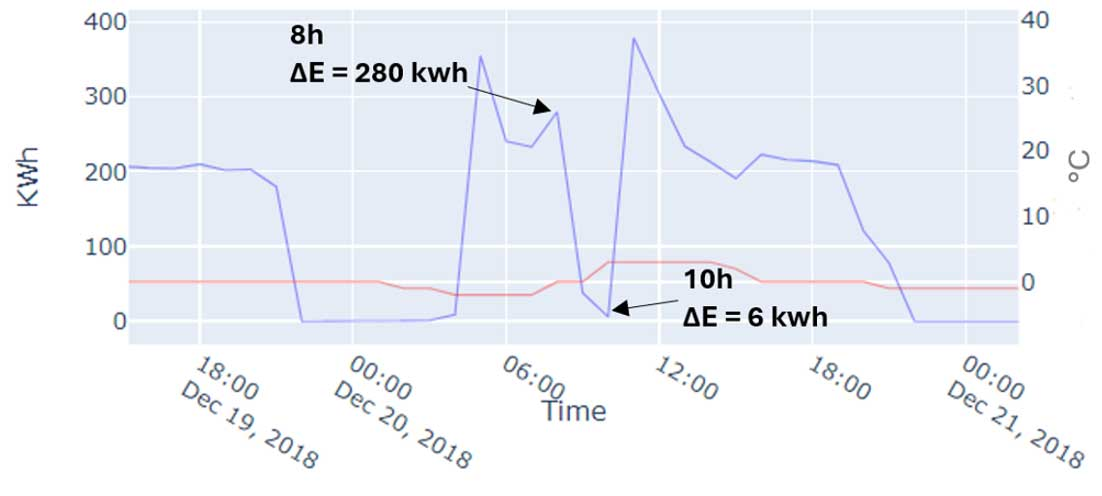

In [ ]:
filename='/content/drive/MyDrive/Projects/FondZaNauku/Prizma/Research/Anomaly detection/Images/Fig.-Sudden-decrease-of-sent-energy-to-the-secondary-supply-line,-due-to-the-exceeding-the-targeted-temperature-of-the-supply-line-in-the-previous-hours.jpg'
display(Image(filename=filename, width=800))

Figure: Sudden decrease of sent energy to the secondary supply line, due to the exceeding the targeted temperature of the supply line in the previous hours

Overall, the methods displayed similar results, as all three noticed the majority of the outliers at the beginning of the heating season and at the end (see Figure below). Because these months of the winter are often warmer and the variation in outside temperature is more pronounced, the heating is also more unpredictable, which results in more outliers detected.

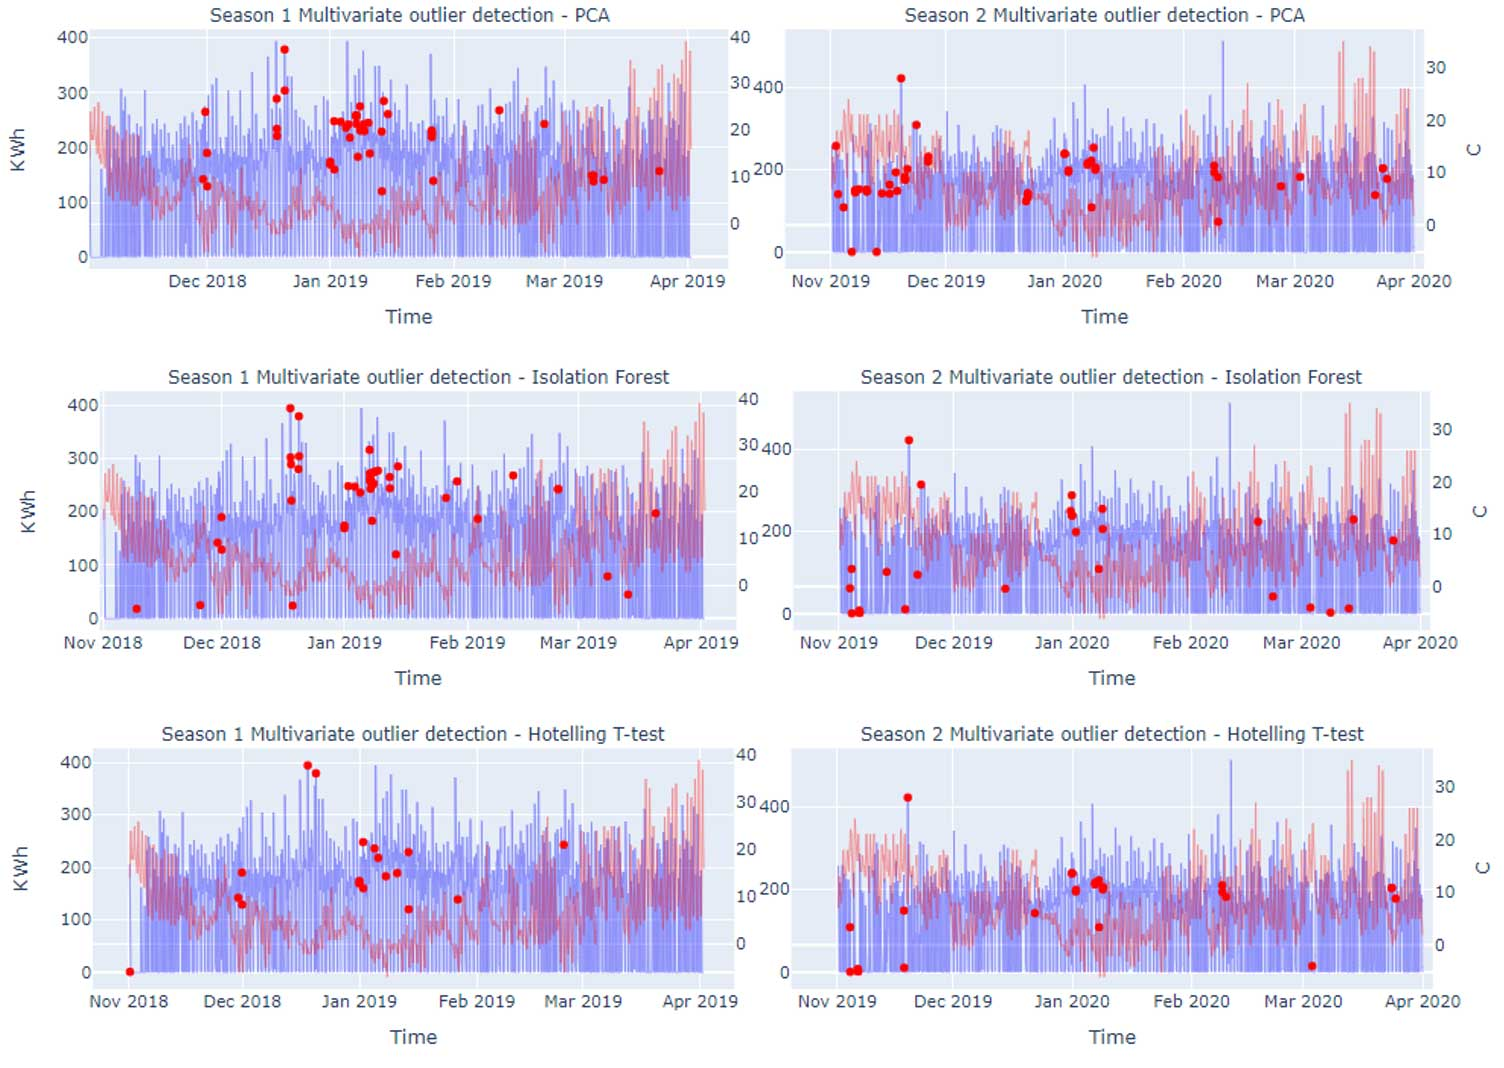

In [ ]:
filename='/content/drive/MyDrive/Projects/FondZaNauku/Prizma/Research/Anomaly detection/Images/Fig.-Detected-outliers-for-each-of-the-methods-in-both-heating-seasons.jpg'
display(Image(filename=filename, width=900))

Figure: Detected outliers for each of the methods in both heating seasons

However, most of the outliers are noticed at the beginning of January, which is odd at first, but understandable when looked more closely. Figure below shows that the majority of the outliers in the month of January are between the first and the 13th January. Because this period is a holiday period of the year, the heating is increased as it is presumed that more users will be staying at home during the days, which is why more outliers are detected.

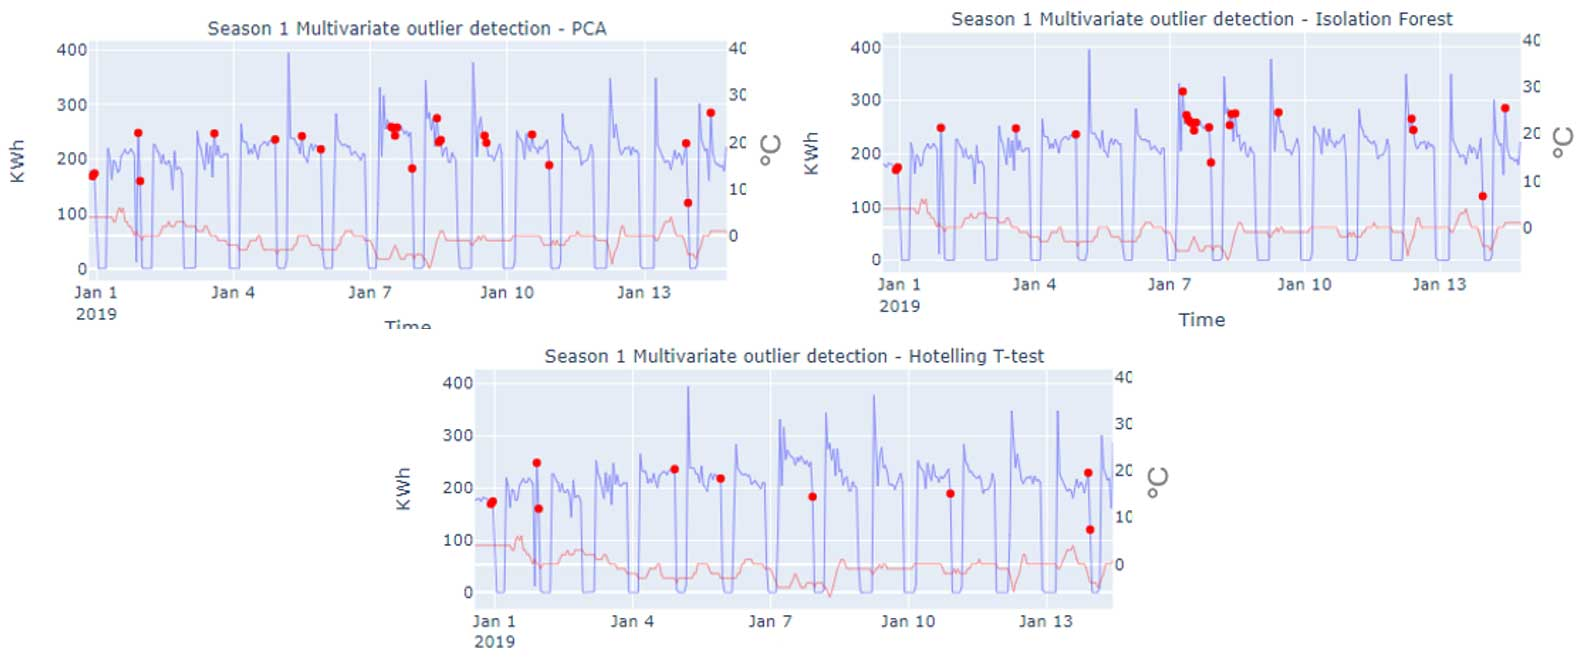

In [ ]:
filename='/content/drive/MyDrive/Projects/FondZaNauku/Prizma/Research/Anomaly detection/Images/Fig.-A-closer-look-at-the-detected-outliers-in-the-first-season-in-the-holiday-period-of-the-year-(01st-Jan-13th-Jan).jpg'
display(Image(filename=filename, width=800))

Figure: A closer look at the detected outliers in the first season in the holiday period of the year (01st Jan-13th Jan)

However, even though the methods detected similar outliers, they did not always detect the exact same one, the methods worked relatively well, but not perfectly. By closely analyzing the results and discussing them with the domain expert, it was concluded that the best choice is to use all three methods (PCA, Isolation Forest, and Hotelling T-test) in conjunction. The outliers which are detected by all three of these methods would be deemed the right outliers, all the others would be false positives.

## Conclusion

In this preliminary research, we have identified the strengths and weaknesses of different methods for the bivariate detection of outliers in DHS operation, based on the features of transmitted heat energy and ambient temperature. PCA and Isolation Forest methods have been adopted as reference ones, producing satisfactory results. The research conclusions are still considered as weak since the adoption of the methods is based on the inspection of the detected outliers by the expert.

In the future, the research will take the direction of considering more features in a multivariate analysis, namely other relevant weather parameters, such as solar irradiance, wind strength and direction. One of the next steps will be to test the effectiveness of the different boosting methods within the multivariate outlier detection problem. For example, PCA can be used to reduce the dimensionality to transform the multivariate to bivariate problem, where other methods can be used to solve it, such as Isolation Forest. Feasibility of the supervised anomaly detection approach will be investigated, based on expert annotated anomalies. Such an approach would enable explicit and direct performance measurement, and it will facilitate the explainability. Also, other methods, namely Deep Learning based ones will be tested. Finally, the research will deliver the software application for walk-forward detection of outliers which are expected to pinpoint ineffective or inefficient heating as well as the fault detection.

## References

1. Al Koussa, Jad, & Månsson, Sara. (2022). Fault detection in district heating substations. 2022: CLIMA 2022 The 14th REHVA HVAC World Congress. CLIMA 2022 Confer-ence.
2.	Chandola, V., Banerjee, A., & Kumar, V. (2009). Anomaly detection: A survey. ACM Computing Surveys, 41(3), 1–58. https://doi.org/10.1145/1541880.1541882
3.	Hotelling, H. (1931). The Generalization of Student’s Ratio. The Annals of Mathemati-cal Statistics, 2(3), 360–378. https://doi.org/10.1214/aoms/1177732979
4.	Li, D., Chen, D., Jin, B., Shi, L., Goh, J., & Ng, S.-K. (2019). MAD-GAN: Multivariate Anomaly Detection for Time Series Data with Generative Adversarial Networks. In I. V. Tetko, V. Kůrková, P. Karpov, & F. Theis (Eds.), Artificial Neural Networks and Machine Learning – ICANN 2019: Text and Time Series (Vol. 11730, pp. 703–716). Springer International Publishing. https://doi.org/10.1007/978-3-030-30490-4_56
5.	Liu, F. T., Ting, K. M., & Zhou, Z.-H. (2012). Isolation-Based Anomaly Detection. ACM Transactions on Knowledge Discovery from Data, 6(1), 1–39. https://doi.org/10.1145/2133360.2133363
6.	Malhotra, P., Ramakrishnan, A., Anand, G., Vig, L., Agarwal, P., & Shroff, G. (2016). LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection. https://doi.org/10.48550/ARXIV.1607.00148
7.	Mbiydzenyuy, G., & Sundell, H. (2022). Pattern Detection in Abnormal District Heating Data. SSRN Electronic Journal. https://doi.org/10.2139/ssrn.4290597
8.	Mingyan Teng. (2010). Anomaly detection on time series. 2010 IEEE International Conference on Progress in Informatics and Computing, 603–608. https://doi.org/10.1109/PIC.2010.5687485
9.	Neumayer, M., Stecher, D., Grimm, S., Maier, A., Bücker, D., & Schmidt, J. (2023). Fault and anomaly detection in district heating substations: A survey on methodology and data sets. Energy, 276, 127569. https://doi.org/10.1016/j.energy.2023.127569
10.	Reprint of: Mahalanobis, P.C. (1936) “On the Generalised Distance in Statistics.” (2018). Sankhya A, 80(S1), 1–7. https://doi.org/10.1007/s13171-019-00164-5
11.	Rousseeuw, P. J., & Hubert, M. (2011). Robust statistics for outlier detection. WIREs Data Mining and Knowledge Discovery, 1(1), 73–79. https://doi.org/10.1002/widm.2
12.	Seem, J. E. (2007). Using intelligent data analysis to detect abnormal energy consumption in buildings. Energy and Buildings, 39(1), 52–58. https://doi.org/10.1016/j.enbuild.2006.03.033
13.	Wold, S., Esbensen, K., & Geladi, P. (1987). Principal component analysis. Chemometrics and Intelligent Laboratory Systems, 2(1–3), 37–52. https://doi.org/10.1016/0169-7439(87)80084-9
14.	Worden, K., & Dulieu-Barton, J. M. (2004). An Overview of Intelligent Fault Detection in Systems and Structures. Structural Health Monitoring, 3(1), 85–98. https://doi.org/10.1177/1475921704041866
15.	Zhang, F., & Fleyeh, H. (2020). Anomaly Detection of Heat Energy Usage in District Heating Substations Using LSTM based Variational Autoencoder Combined with Physical Model. 2020 15th IEEE Conference on Industrial Electronics and Applications (ICIEA), 153–158. https://doi.org/10.1109/ICIEA48937.2020.9248108
